<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/main/_ChangeDetection_prediction_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DEMO] Deep Active Learning in Remote Sensing for data efficient Change Detection


Code and data:

In [1]:
!git clone https://github.com/previtus/ChangeDetectionProject.git

Cloning into 'ChangeDetectionProject'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 424 (delta 16), reused 1 (delta 0), pack-reused 393
Receiving objects: 100% (424/424), 2.12 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%tensorflow_version 1.x

!pip install -U -q PyDrive
!pip install tqdm
!pip install mock
!pip install -U segmentation-models==0.2.0
!pip install 'h5py==2.10.0' --force-reinstall
!pip install tifffile 
!pip install imagecodecs 

In [4]:
%cd /content/ChangeDetectionProject
!pwd

/content/ChangeDetectionProject
/content/ChangeDetectionProject


In [16]:
import numpy 
import tifffile as tiff 

In [5]:
# Trained models and sample data:

#BACKBONE = 'resnet34'
#custom_weights_file = "model_UNet-Vgg16_DSM_in01_95percOfTrain_8batch_100ep_dsm01proper.h5" # None
#custom_weights_file = "imagenet"

downloaded = drive.CreateFile({'id': '1Yv8ik5xdbkB8b4etMW60_uP3Kw2fdA57'})
downloaded.GetContentFile('weightsModel2_cleanManual_100ep_ImagenetWgenetW_resnet50-16batch_Augmentation1to1_ClassWeights1to3_TestVal_[KFold_0z5].h5')
#downloaded.GetContentFile(custom_weights_file)

downloaded = drive.CreateFile({'id': '1V-V73WLOfzYtXEb95LDIlkTz84437hEC'})
downloaded.GetContentFile('samples.zip')

In [6]:
!ls

 ActiveLearning
 ActiveLearningLoop.py
 ___al_run.sh
 _data_inspection.py
 DataLoader.py
 DataPreprocesser.py
 DatasetInstance_OurAerial.py
 Dataset.py
 Debugger.py
 demo
 ___eval_run.sh
 Evaluator.py
 exclude.txt
 experiment_focal_loss.py
 __howto.txt
 _illustration.jpg
 loss_weighted_crossentropy.py
 main_al.py
 main_evaluate__loadOldLarge.py
 main_evaluate__plotOldLarge.py
 main_evaluate.py
 main.py
 Model2_builder.py
 Model2_SiamUnet_Encoder.py
 ModelHandler.py
 _multiprocessing_sample.py
 __OUTPUTS
 plot_al_results.py
 prebake_entire_dataset.py
 README.md
 run_al_exp1.sh
 run_crossval_resnet101_10folds.sh
 samples.zip
 _serverside_test_libraries.py
 Settings.py
 try_with_MC_BatchNorm_Idea2asloop.py
 try_with_MC_BatchNorm_Idea3asloop.py
'weightsModel2_cleanManual_100ep_ImagenetWgenetW_resnet50-16batch_Augmentation1to1_ClassWeights1to3_TestVal_[KFold_0z5].h5'


Load and prepare the model and datapreprocessor (with values from train set for this exact model).

In [7]:
import matplotlib, os
if not('DISPLAY' in os.environ):
    matplotlib.use("Agg")

import DataLoader, DataPreprocesser, Dataset, Debugger, Settings, ModelHandler, Evaluator
from timeit import default_timer as timer
from datetime import *

months = ["unk","jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
month = (months[datetime.now().month])
day = str(datetime.now().day)

import Settings
import mock
args = mock.Mock()
args.name = "Run-"+month+"-"+day
args.KFOLDS = "5"
args.FOLD_I = "0"
args.model_backend = "resnet50"
args.train_epochs = "100"
args.train_batch = "16"

if True:
    print(args)

    settings = Settings.Settings(args)
    settings.TestDataset_Fold_Index = int(args.FOLD_I)
    settings.TestDataset_K_Folds = int(args.KFOLDS)
    assert settings.TestDataset_Fold_Index < settings.TestDataset_K_Folds
    kfold_txt = "KFold_"+str(settings.TestDataset_Fold_Index)+"z"+str(settings.TestDataset_K_Folds)
    print(kfold_txt)

    # resnet 101 approx 5-6 hours (per fold - might be a bit less ...)
    # resnet 50  approx 3-4 hours
    model_txt = "cleanManual_"+args.train_epochs+"ep_ImagenetWgenetW_"+args.model_backend+"-"+args.train_batch+"batch_Augmentation1to1_ClassWeights1to3_TestVal"
    print(model_txt)

    datapreprocessor = DataPreprocesser.DataPreprocesser(settings, 3)
    
    datapreprocessor.zeroweighting_L_means_per_channel = [128.97206, 110.9056, 118.42062, 95.341675]
    datapreprocessor.zeroweighting_L_stds_per_channel = [52.3949, 50.5274, 45.264183, 39.304928]

    datapreprocessor.zeroweighting_R_means_per_channel = [153.98038, 119.60732, 118.80906, 112.634346]
    datapreprocessor.zeroweighting_R_stds_per_channel = [54.66875, 48.597534, 46.159058, 44.616997]
    
    dataset = Dataset.Dataset(settings, init_source = -1)
    evaluator = Evaluator.Evaluator(settings)

    show = False
    save = True

    settings.model_backend = args.model_backend
    settings.train_epochs = int(args.train_epochs)
    settings.train_batch = int(args.train_batch)
    model = ModelHandler.ModelHandler(settings, dataset)

    model.model.load("weightsModel2_cleanManual_100ep_ImagenetWgenetW_resnet50-16batch_Augmentation1to1_ClassWeights1to3_TestVal_[KFold_0z5].h5")
    #model.model.load(custom_weights_file)
    model.model.model.summary()
    

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


<Mock id='140401578226704'>
KFold_0z5
cleanManual_100ep_ImagenetWgenetW_resnet50-16batch_Augmentation1to1_ClassWeights1to3_TestVal
Init manually from data and labels
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

94593024/94592056 [==============================] - 2s 0us/step
Model loaded:
model.input [<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>]
model.output Tensor("softmax/truediv:0", shape=(?, ?, ?, 2), dtype=float32)

Tensor("loss/softmax_loss/loss/mul:0", shape=(?, ?, ?, 2), dtype=float32)
Tensor("loss/softmax_loss/loss/mul_2:0", shape=(?, ?, ?, 2), dtype=float32)
Model: "u-resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            


In [8]:
#from Model2_builder import *
#BACKBONE = 'resnet34'
#custom_weights_file = "model_UNet-Resnet34_DSM_in01_95percOfTrain_8batch_100ep_dsm01proper.h5" # None
#custom_weights_file = "imagenet"
#model = SiameseUnet() #BACKBONE, encoder_weights=custom_weights_file, classes=3, activation='softmax', input_shape=(256, 256, 3))
#print("Model loaded:")
#print("model.input", model.input)
#print("model.output", model.output)


In [9]:
!unzip -q samples

In [10]:
!ls samples/*.PNG

samples/strip1-2012_6467.PNG  samples/strip1-2015_6467.PNG
samples/strip1-2012_6472.PNG  samples/strip1-2015_6472.PNG
samples/strip1-2012_6518.PNG  samples/strip1-2015_6518.PNG
samples/strip1-2012_6889.PNG  samples/strip1-2015_6889.PNG


Predict on an example of data:

before  (512, 512, 3)
after  (512, 512, 3)
(1, 512, 512, 3)


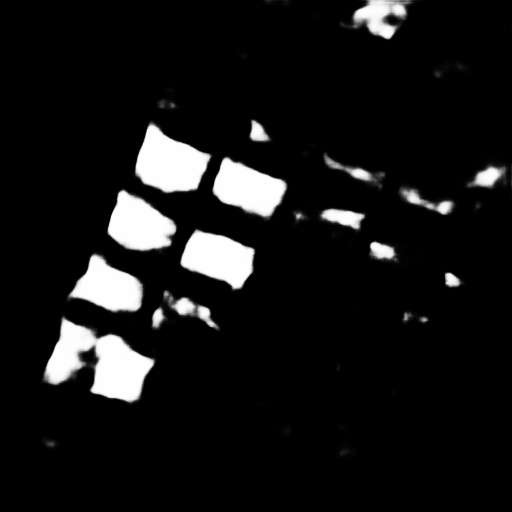

In [25]:
from skimage import io
import numpy as np
import PIL
import IPython
import tifffile as tiff

def load_raster_image(filename):
  if 'tif' in filename:
    img = io.imread(filename, plugin='pil')
  else:
    img = io.imread(filename)
  matrix = img #[0:512,0:512,:] 
  #print(matrix)
  arr = np.asarray(matrix)
  return arr

def predict(left_path, right_path):
    i1 = load_raster_image(left_path)
    i2 = load_raster_image(right_path)

    print("before ", i1.shape)
    print("after ", i2.shape)

    test_L = np.asarray([i1]); print(test_L.shape)
    test_R = np.asarray([i2])
    orig_L, orig_R = test_L, test_R
    data = [test_L, test_R]

    # 2 PREPROCESSED IT
    data = datapreprocessor.apply_on_a_set_nondestructively(data, no_labels = True)
    test_L, test_R = data

    if test_L.shape[3] > 3:
      # 3 channels only - rgb
      test_L = test_L[:,:,:,1:4]
      test_R = test_R[:,:,:,1:4]

    models = [model.model.model]
    # 3 PREDICTION
    predicted = models[0].predict(x=[test_L, test_R], batch_size=4)

    #predicted = model.predict(x=[test_L, test_R], batch_size=4)


    predicted = predicted[:, :, :, 1]
    p = predicted[0]
    l = orig_L[0,:,:,1:4]
    r = orig_R[0,:,:,1:4]

    return p, l, r

#path1 = "samples/strip1-2012_6467.PNG"  
#path2 = "samples/strip1-2015_6467.PNG"

# 1 LOADED NEW DATA FOR PREDICTION
#path1 = "samples/before256.png" #strip1-2012_6467.PNG"
#path2 = "samples/after256.png" #strip1-2015_6467.PNG"

path1 = "samples/BeforeMegaBKK2.tif"
path2 = "samples/AfterMegaBKK2.tif"

p, l, r = predict(path1, path2)

new_p = PIL.Image.fromarray(p*255.0)
if new_p.mode != 'RGB':
  new_p = new_p.convert('RGB')
new_p.save('samples/OutputMegaBKK2.tif')
IPython.display.display(new_p)

And to double check what were the original inputs?

In [ ]:
def save_image(image, name):
    PIL.Image.fromarray(image, 'RGB').save(name)

def show_three(l,r,p):
    # Show the triple:
    new_p = PIL.Image.fromarray(p*255.0)
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    rgbpred = np.asarray(new_p)

    #print(rgbpred.shape)
    #print(l.shape)
    #print(r.shape)

    horizontal = np.concatenate(([l,r,rgbpred]), axis = 1)
    save_image(horizontal, "demo.png")

    from IPython.display import Image
    return Image("demo.png", width=512)

show_three(l,r,p)

In [ ]:
!ls samples/*.PNG

# Demo predictions:

In [ ]:
# samples/strip1-2012_6467.PNG  samples/strip1-2015_6467.PNG
p1 = "samples/strip1-2012_6472.PNG"#"samples/before256.png"
p2 = "samples/strip1-2015_6472.PNG"#"samples/after256.png"

p,l,r = predict(p1, p2)
show_three(l,r,p)

In [ ]:
#   
p1 = "samples/strip1-2012_6467.PNG" #samples/Before3.tiff"#"samples/before256.png"
p2 = "samples/strip1-2015_6467.PNG" #samples/After3.tiff"#"samples/after256.png"

p,l,r = predict(p1, p2)
show_three(l,r,p)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# samples/strip1-2012_6472.PNG  samples/strip1-2015_6472.PNG

p1 = "samples/strip1-2012_6518.PNG"
p2 = "samples/strip1-2015_6518.PNG"

p,l,r = predict(p1, p2)
show_three(l,r,p)

In [ ]:
# samples/strip1-2012_6889.PNG  samples/strip1-2015_6889.PNG

p1 = "samples/strip1-2012_6889.PNG"
p2 = "samples/strip1-2015_6889.PNG"

p,l,r = predict(p1, p2)
show_three(l,r,p)

In [ ]:
# samples/strip1-2012_6518.PNG  samples/strip1-2015_6518.PNG

p1 = "samples/strip1-2012_6518.PNG"
p2 = "samples/strip1-2015_6518.PNG"

p,l,r = predict(p1, p2)
show_three(l,r,p)

### Bonus note:

In [ ]:
# If we give the model a wrong ordering of the pair of samples (from the year 2012 and year 2015)
# ... we will still get a prediction, however the accuracy suffers (see the above prediction for comparison)
# This is due to visual quality differences between the two sets (such as different weather and time of capture of the data).

p,l,r = predict(p2, p1)
show_three(l,r,p)